In [1]:
from torchvision.transforms import Compose, ToTensor, Lambda
from torchvision.datasets.mnist import FashionMNIST
from torch.utils.data import DataLoader

transform = Compose(
    [
        ToTensor(),
        Lambda(lambda x: (x - 0.5) * 2),
    ]
)
dataset = FashionMNIST("./datasets", download=True, train=True, transform=transform)
loader = DataLoader(dataset, batch_size=128, shuffle=True)

In [2]:
import torch
import torch.nn as nn


class AutoEncoderBlock(nn.Module):
    def __init__(
        self,
        shape,
        in_channel,
        out_channel,
        kernel_size=3,
        stride=1,
        padding=1,
        activation=None,
        normalize=True,
    ):
        super().__init__()
        self.layer_norm = nn.LayerNorm(shape)
        self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel_size, stride, padding)
        self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel_size, stride, padding)
        self.activation = nn.SiLU() if activation is None else activation
        self.normalize = normalize

    def forward(self, x):
        out = self.layer_norm(x) if self.normalize else x
        out = self.conv_1(out)
        out = self.activation(out)
        out = self.conv_2(out)
        out = self.activation(out)
        return out

In [3]:
def sinusoidal_embedding(n, d):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d)
    w_k = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)])
    w_k = w_k.reshape((1, d))
    t = torch.arange(n).reshape((n, 1))
    embedding[:,::2] = torch.sin(t * w_k[:,::2])
    embedding[:,1::2] = torch.cos(t * w_k[:,::2])
    return embedding

In [4]:
class TimeEmbeddingBlock(nn.Module):
    def __init__(
        self,
        dim_in,
        dim_out,
    ):
        super().__init__()
        self.layer_1 = nn.Linear(dim_in, dim_out)
        self.activation = nn.SiLU()
        self.layer_2 = nn.Linear(dim_out, dim_out)

    def forward(self, x):
        out = self.layer_1(x)
        out = self.activation(out)
        out = self.layer_2(out)
        return out

In [5]:
class UNet(nn.Module):
    def __init__(self, n_steps=1000, time_embed_dim=100):
        super().__init__()
        # Sinusoidal position embedding
        self.time_embed = nn.Embedding(n_steps, time_embed_dim)
        self.time_embed.weight.data = sinusoidal_embedding(n_steps, time_embed_dim)
        self.time_embed.requires_grad_(False)

        # encoder
        ## layer 1
        self.layer_1_time_embedding = TimeEmbeddingBlock(time_embed_dim, 1)
        self.layer_1_block = nn.Sequential(
            AutoEncoderBlock(shape=(1, 28, 28), in_channel=1, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
        )
        self.layer_1_down = nn.Conv2d(10, 10, 4, 2, 1)
        ## layer 2
        self.layer_2_time_embedding = TimeEmbeddingBlock(time_embed_dim, 10)
        self.layer_2_block = nn.Sequential(
            AutoEncoderBlock(shape=(10, 14, 14), in_channel=10, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=20),
        )
        self.layer_2_down = nn.Conv2d(20, 20, 4, 2, 1)

        ## layer 3
        self.layer_3_time_embedding = TimeEmbeddingBlock(time_embed_dim, 20)
        self.layer_3_block = nn.Sequential(
            AutoEncoderBlock(shape=(20, 7, 7), in_channel=20, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=40),
        )
        self.layer_3_down = nn.Sequential(
            nn.Conv2d(40, 40, 2, 1), nn.SiLU(), nn.Conv2d(40, 40, 4, 2, 1)
        )
        # bottleneck
        self.layer_bottleneck_time_embedding = TimeEmbeddingBlock(time_embed_dim, 40)
        self.layer_bottleneck_block = nn.Sequential(
            AutoEncoderBlock(shape=(40, 3, 3), in_channel=40, out_channel=20),
            AutoEncoderBlock(shape=(20, 3, 3), in_channel=20, out_channel=20),
            AutoEncoderBlock(shape=(20, 3, 3), in_channel=20, out_channel=40),
        )

        # decoder
        ## layer 4
        self.layer_4_up = nn.Sequential(
            nn.ConvTranspose2d(40, 40, 4, 2, 1),
            nn.SiLU(),
            nn.ConvTranspose2d(40, 40, 2, 1),
        )
        self.layer_4_time_embedding = TimeEmbeddingBlock(time_embed_dim, 80)
        self.layer_4_block = nn.Sequential(
            AutoEncoderBlock(shape=(80, 7, 7), in_channel=80, out_channel=40),
            AutoEncoderBlock(shape=(40, 7, 7), in_channel=40, out_channel=20),
            AutoEncoderBlock(shape=(20, 7, 7), in_channel=20, out_channel=20),
        )

        ## layer 5
        self.layer_5_up = nn.ConvTranspose2d(20, 20, 4, 2, 1)
        self.layer_5_time_embedding = TimeEmbeddingBlock(time_embed_dim, 40)
        self.layer_5_block = nn.Sequential(
            AutoEncoderBlock(shape=(40, 14, 14), in_channel=40, out_channel=20),
            AutoEncoderBlock(shape=(20, 14, 14), in_channel=20, out_channel=10),
            AutoEncoderBlock(shape=(10, 14, 14), in_channel=10, out_channel=10),
        )

        ## layer 6
        self.layer_6_up = nn.ConvTranspose2d(10, 10, 4, 2, 1)
        self.layer_6_time_embedding = TimeEmbeddingBlock(time_embed_dim, 20)
        self.layer_6_block = nn.Sequential(
            AutoEncoderBlock(shape=(20, 28, 28), in_channel=20, out_channel=10),
            AutoEncoderBlock(shape=(10, 28, 28), in_channel=10, out_channel=10),
            AutoEncoderBlock(
                shape=(10, 28, 28), in_channel=10, out_channel=10, normalize=False
            ),
        )

        self.conv_out = nn.Conv2d(10, 1, 3, 1, 1)

    def forward(self, x_noise, time_tensor):
        # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
        # prepare
        te = self.time_embed(time_tensor)
        n = len(x_noise)

        # encoding
        out_1_te = self.layer_1_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 1, 1, 1)
        out_1_result = self.layer_1_block(x_noise + out_1_te)  # (N, 10, 28, 28)
        out_1_down = self.layer_1_down(out_1_result)  # (N, 10, 14, 14)

        out_2_te = self.layer_2_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 10, 1, 1)
        out_2_result = self.layer_2_block(out_1_down + out_2_te)  # (N, 20, 14, 14)
        out_2_down = self.layer_2_down(out_2_result)  # (N, 20, 7, 7)

        out_3_te = self.layer_3_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 20, 1, 1)
        out_3_result = self.layer_3_block(out_2_down + out_3_te)  # (N, 40, 7, 7)
        out_3_down = self.layer_3_down(out_3_result)  # (N, 40, 3, 3)

        # bottleneck
        out_bn_te = self.layer_bottleneck_time_embedding(te).reshape(
            n, -1, 1, 1
        )  # (N, 40, 1, 1)
        out_bn_result = self.layer_bottleneck_block(
            out_3_down + out_bn_te
        )  # (N, 40, 3, 3)

        # decoding
        out_4_up_result = self.layer_4_up(out_bn_result)  # (N, 40, 7, 7)
        out_4_concat = torch.cat(
            (out_3_result, out_4_up_result), dim=1
        )  # (N, 80, 7, 7)
        out_4_te = self.layer_4_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 80, 1, 1)
        out_4_result = self.layer_4_block(out_4_concat + out_4_te)  # (N, 20, 7, 7)

        out_5_up_result = self.layer_5_up(out_4_result)  # (N, 20, 14, 14)
        out_5_concat = torch.cat(
            (out_2_result, out_5_up_result), dim=1
        )  # (N, 40, 14, 14)
        out_5_te = self.layer_5_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 40, 1, 1)
        out_5_result = self.layer_5_block(out_5_concat + out_5_te)  # (N, 10, 14, 14)

        out_6_up_result = self.layer_6_up(out_5_result)  # (N, 10, 28, 28)
        out_6_concat = torch.cat(
            (out_1_result, out_6_up_result), dim=1
        )  # (N, 20, 28, 28)
        out_6_te = self.layer_6_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 20, 1, 1)
        out_6_result = self.layer_6_block(out_6_concat + out_6_te)  # (N, 10, 28, 28)

        out = self.conv_out(out_6_result)  # (N, 1, 28, 28)
        return out

In [6]:
n_steps, time_emb_dim = 1000, 100
time_embed = nn.Embedding(n_steps, time_emb_dim)
time_embed.weight.data = sinusoidal_embedding(n_steps, time_emb_dim)
time_embed.requires_grad_(False)

Embedding(1000, 100)

In [7]:
unet = UNet()

In [8]:
# Starting from random noise
for batch in loader:
    x = batch[0]
    break

with torch.no_grad():
    t = 1
    x_noise = x
    time_tensor = (torch.ones(x_noise.size(0), 1) * t).long()
    
    
    # x is (N, 2, 28, 28) (image with positional embedding stacked on channel dimension)
    # prepare
    te = unet.time_embed(time_tensor)
    n = len(x)

    # encoding
    out_1_te = unet.layer_1_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 1, 1, 1)
    out_1_result = unet.layer_1_block(x_noise + out_1_te)  # (N, 10, 28, 28)
    out_1_down = unet.layer_1_down(out_1_result)  # (N, 10, 14, 14)

    out_2_te = unet.layer_2_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 1, 1, 1)
    out_2_result = unet.layer_2_block(out_1_down + out_2_te)  # (N, 20, 14, 14)
    out_2_down = unet.layer_2_down(out_2_result)  # (N, 20, 7, 7)

    out_3_te = unet.layer_3_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 1, 1, 1)
    out_3_result = unet.layer_3_block(out_2_down + out_3_te)  # (N, 40, 7, 7)
    out_3_down = unet.layer_3_down(out_3_result)  # (N, 40, 3, 3)

    # bottleneck
    out_bn_te = unet.layer_bottleneck_time_embedding(te).reshape(
        n, -1, 1, 1
    )  # (N, 20, 1, 1)
    out_bn_result = unet.layer_bottleneck_block(
        out_3_down + out_bn_te
    )  # (N, 40, 7, 7)

    # decoding
    out_4_up_result = unet.layer_4_up(out_bn_result)  # (N, 40, 7, 7)
    out_4_concat = torch.cat(
        (out_3_result, out_4_up_result), dim=1
    )  # (N, 80, 7, 7)
    out_4_te = unet.layer_4_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 20, 1, 1)
    out_4_result = unet.layer_4_block(out_4_concat + out_4_te)  # (N, 20, 7, 7)

    out_5_up_result = unet.layer_5_up(out_4_result)  # (N, 20, 14, 14)
    out_5_concat = torch.cat(
        (out_2_result, out_5_up_result), dim=1
    )  # (N, 40, 14, 14)
    out_5_te = unet.layer_5_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 20, 1, 1)
    out_5_result = unet.layer_5_block(out_5_concat + out_5_te)  # (N, 10, 14, 14)

    out_6_up_result = unet.layer_6_up(out_5_result)  # (N, 10, 28, 28)
    out_6_concat = torch.cat(
        (out_1_result, out_6_up_result), dim=1
    )  # (N, 20, 28, 28)
    out_6_te = unet.layer_6_time_embedding(te).reshape(n, -1, 1, 1)  # (N, 20, 1, 1)
    out_6_result = unet.layer_6_block(out_6_concat + out_6_te)  # (N, 10, 28, 28)
    out = unet.conv_out(out_6_result)  # (N, 1, 28, 28)

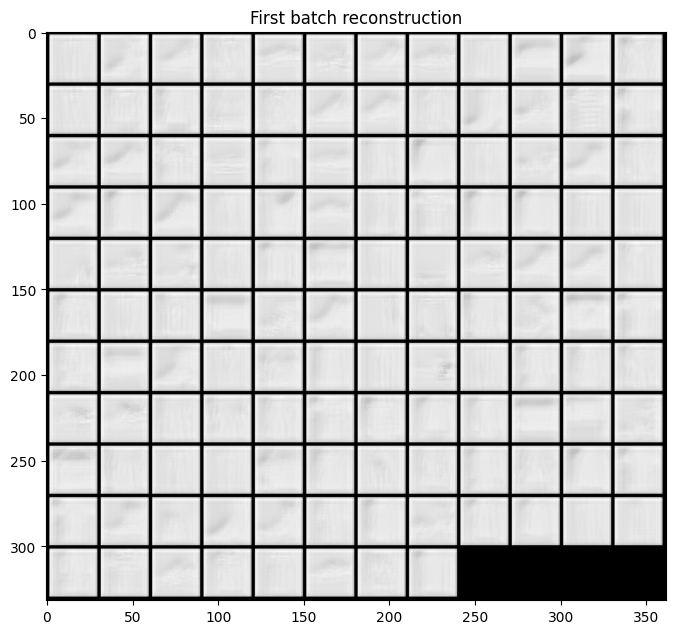

In [9]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid


out_x_grid = make_grid(out, nrow=12).numpy()

plt.figure(figsize=(8, 8))
plt.title("First batch reconstruction")
plt.imshow(out_x_grid[0], cmap="gray")

In [10]:
import torch
import torch.nn as nn


class DDPM(nn.Module):
    def __init__(
        self,
        network,
        n_steps=200,
        min_beta=10**-4,
        max_beta=0.02,
    ):
        super().__init__()
        self.n_steps = n_steps
        self.network = network
        
        # Number of steps is typically in the order of thousands
        self.betas = nn.Parameter(torch.linspace(min_beta, max_beta, n_steps))
        self.betas.requires_grad_(False)

        self.alphas = nn.Parameter(1 - self.betas)
        self.alphas.requires_grad_(False)

        self.alpha_bars = nn.Parameter(
            torch.tensor(
                [torch.prod(self.alphas[: i + 1]) for i in range(len(self.alphas))]
            )
        )
        self.alpha_bars.requires_grad_(False)

    def forward(self, x0, t, eta=None):
        # Make input image more noisy (we can directly skip to the desired step)
        n, c, h, w = x0.shape
        device = x0.device
        a_bar = self.alpha_bars[t]

        if eta is None:
            eta = torch.randn(n, c, h, w).to(device)

        noisy = (
            a_bar.sqrt().reshape(n, 1, 1, 1) * x0
            + (1 - a_bar).sqrt().reshape(n, 1, 1, 1) * eta
        )
        return noisy

    def backward(self, x, t):
        # Run each image through the network for each timestep t in the vector t.
        # The network returns its estimation of the noise that was added.
        return self.network(x, t)


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
n_steps = 200

unet = UNet()
ddpm = DDPM(unet, n_steps=n_steps)
_ = ddpm.to(device)

Text(0.5, 1.0, 'Original Image')

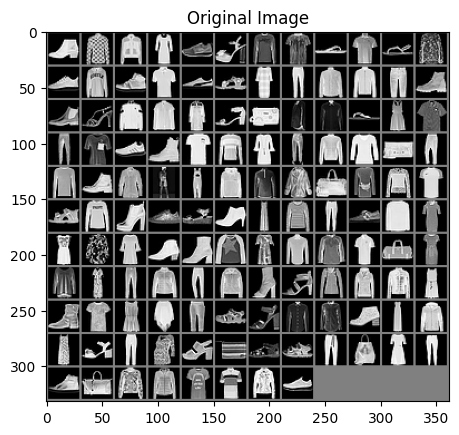

In [13]:
# forward process
for batch in loader:
    x = batch[0]
    break
x_frame = make_grid(x, nrow=12).numpy()[0]
plt.imshow(x_frame, cmap="gray")
plt.title("Original Image")

In [14]:
percents = [0.25, 0.5, 0.75, 1]
x_frames = []

with torch.no_grad():
    x0 = x.to(device)
    for percent in percents:
        time_steps = [int(percent * ddpm.n_steps) - 1 for _ in range(len(x))] # all values are same
        x_noise = ddpm(x0, time_steps)
        x_frame = make_grid(x_noise.cpu(), nrow=12).numpy()[0]
        x_frames += [x_frame]

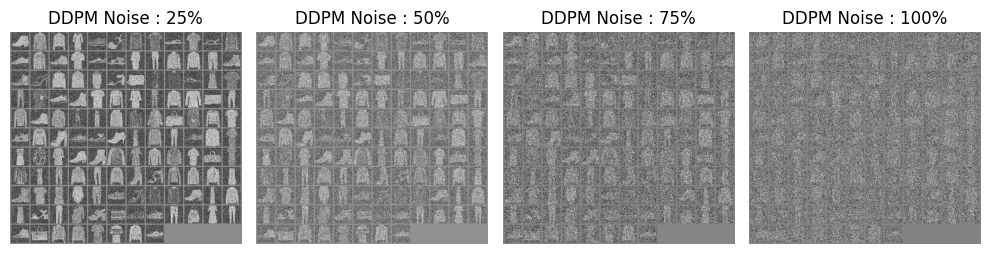

In [15]:
fig, axes = plt.subplots(ncols=4, figsize=(10, 7))

for idx, x in enumerate(x_frames):
    axes[idx].imshow(x, cmap="gray")
    axes[idx].set_title(f"DDPM Noise : {int(percents[idx]*100)}%")
    axes[idx].axis("off")

plt.tight_layout()
plt.show()

In [16]:
import torch.optim as optim
from tqdm import tqdm

mse_loss_fn = nn.MSELoss()
n_steps = ddpm.n_steps

n_epochs = 30
ddpm_opt = optim.Adam(ddpm.parameters(), lr=1e-3)


for epoch in range(n_epochs):
    epoch_loss = 0.0
    for step, batch in enumerate(tqdm(loader, desc=f"Epoch {epoch + 1}/{n_epochs}")):
        ddpm.train()
        #
        # 1. Load data
        #
        x0 = batch[0].to(device)
        batch_size = x0.size(0)

        #
        # 2. Picking some noise for each of the images in the batch, a timestep and the respective alpha_bars
        #
        eta = torch.randn_like(x0).to(device)
        t = torch.randint(0, n_steps, (batch_size,)).to(device)

        #
        # 3. Forward process: Computing the noisy image based on x0 and the time-step
        #
        x_noise = ddpm(x0, t, eta)

        #
        # 4.  Backward process: Getting model estimation of noise based on the images and the time-step
        #
        eta_theta = ddpm.backward(x_noise, t.reshape(batch_size, -1))

        #
        # 5. Update ddpm
        #
        ddpm_opt.zero_grad()
        mse_loss = mse_loss_fn(eta_theta, eta)
        mse_loss.backward()
        ddpm_opt.step()

        epoch_loss += mse_loss.item() * len(x0) / len(loader.dataset)

    log_string = f"Loss at epoch {epoch + 1}: {epoch_loss:.3f}"

    print(log_string)

Epoch 1/30: 100%|██████████| 469/469 [00:20<00:00, 22.35it/s]


Loss at epoch 1: 0.256


Epoch 2/30: 100%|██████████| 469/469 [00:17<00:00, 26.60it/s]


Loss at epoch 2: 0.137


Epoch 3/30: 100%|██████████| 469/469 [00:17<00:00, 26.19it/s]


Loss at epoch 3: 0.123


Epoch 4/30: 100%|██████████| 469/469 [00:18<00:00, 25.98it/s]


Loss at epoch 4: 0.117


Epoch 5/30: 100%|██████████| 469/469 [00:17<00:00, 26.66it/s]


Loss at epoch 5: 0.113


Epoch 6/30: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]


Loss at epoch 6: 0.109


Epoch 7/30: 100%|██████████| 469/469 [00:18<00:00, 25.91it/s]


Loss at epoch 7: 0.107


Epoch 8/30: 100%|██████████| 469/469 [00:17<00:00, 26.45it/s]


Loss at epoch 8: 0.105


Epoch 9/30: 100%|██████████| 469/469 [00:18<00:00, 25.77it/s]


Loss at epoch 9: 0.104


Epoch 10/30: 100%|██████████| 469/469 [00:18<00:00, 25.73it/s]


Loss at epoch 10: 0.103


Epoch 11/30: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]


Loss at epoch 11: 0.101


Epoch 12/30: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]


Loss at epoch 12: 0.100


Epoch 13/30: 100%|██████████| 469/469 [00:17<00:00, 26.27it/s]


Loss at epoch 13: 0.099


Epoch 14/30: 100%|██████████| 469/469 [00:18<00:00, 25.87it/s]


Loss at epoch 14: 0.100


Epoch 15/30: 100%|██████████| 469/469 [00:17<00:00, 26.49it/s]


Loss at epoch 15: 0.098


Epoch 16/30: 100%|██████████| 469/469 [00:17<00:00, 26.25it/s]


Loss at epoch 16: 0.097


Epoch 17/30: 100%|██████████| 469/469 [00:17<00:00, 26.12it/s]


Loss at epoch 17: 0.097


Epoch 18/30: 100%|██████████| 469/469 [00:18<00:00, 26.02it/s]


Loss at epoch 18: 0.096


Epoch 19/30: 100%|██████████| 469/469 [00:17<00:00, 26.24it/s]


Loss at epoch 19: 0.097


Epoch 20/30: 100%|██████████| 469/469 [00:17<00:00, 26.18it/s]


Loss at epoch 20: 0.095


Epoch 21/30: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]


Loss at epoch 21: 0.095


Epoch 22/30: 100%|██████████| 469/469 [00:17<00:00, 26.07it/s]


Loss at epoch 22: 0.095


Epoch 23/30: 100%|██████████| 469/469 [00:17<00:00, 26.08it/s]


Loss at epoch 23: 0.095


Epoch 24/30: 100%|██████████| 469/469 [00:18<00:00, 25.68it/s]


Loss at epoch 24: 0.094


Epoch 25/30: 100%|██████████| 469/469 [00:17<00:00, 26.34it/s]


Loss at epoch 25: 0.094


Epoch 26/30: 100%|██████████| 469/469 [00:17<00:00, 26.21it/s]


Loss at epoch 26: 0.093


Epoch 27/30: 100%|██████████| 469/469 [00:18<00:00, 25.96it/s]


Loss at epoch 27: 0.093


Epoch 28/30: 100%|██████████| 469/469 [00:17<00:00, 26.11it/s]


Loss at epoch 28: 0.094


Epoch 29/30: 100%|██████████| 469/469 [00:18<00:00, 25.69it/s]


Loss at epoch 29: 0.093


Epoch 30/30: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]

Loss at epoch 30: 0.093


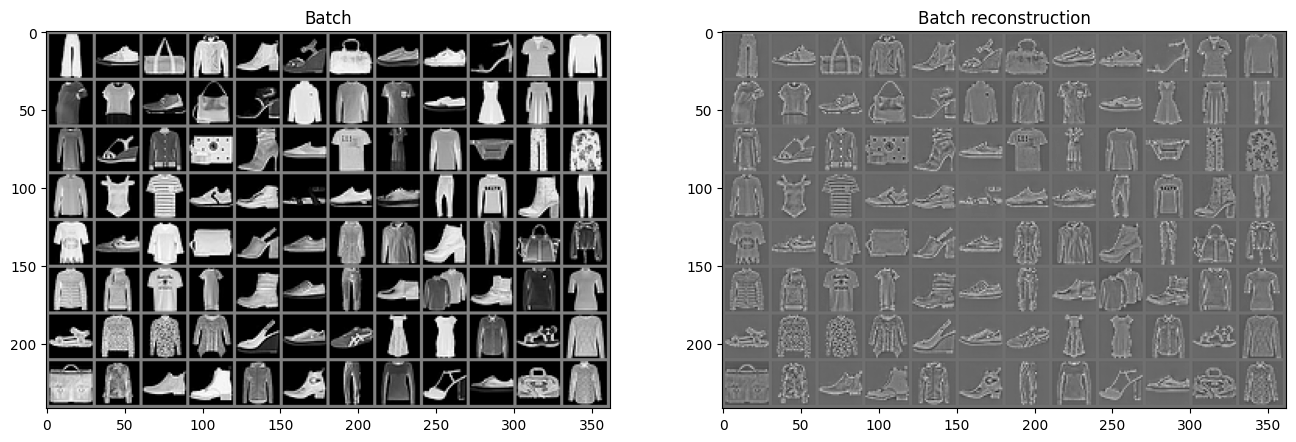

In [21]:
t = 200

with torch.no_grad():    
    x = batch[0].to(device)
    time_tensor = (torch.ones(x.size(0), 1) * t).long().to(device)
    recon_x = unet(x, time_tensor)
recon_x = recon_x.cpu()

x_grid = make_grid(x.cpu(), nrow=12).numpy()
recon_x_grid = make_grid(recon_x, nrow=12).numpy()

fig, axes = plt.subplots(ncols=2, figsize=(16, 8))

axes[0].set_title("Batch")
axes[0].imshow(x_grid[0], cmap="gray")

axes[1].set_title("Batch reconstruction")
axes[1].imshow(recon_x_grid[0], cmap="gray")

In [18]:
import numpy as np


frame_num = 16
frame_idxs = np.linspace(0, ddpm.n_steps, frame_num).astype(np.uint)

x_frames = []
new_x_frames = []
new_new_x_frames = []

with torch.no_grad():
    ddpm.eval()
    # Starting from random noise
    x = torch.randn(*batch[0].shape).to(device)

    for idx, t in enumerate(list(range(ddpm.n_steps))[::-1]):
        # Estimating noise to be removed
        time_tensor = (torch.ones(x.size(0), 1) * t).long().to(device)
        eta_theta = ddpm.backward(x, time_tensor)

        alpha_t = ddpm.alphas[t]
        alpha_t_bar = ddpm.alpha_bars[t]

        # Partially denoising the image
        new_x = (1 / alpha_t.sqrt()) * (x - (1 - alpha_t) / (1 - alpha_t_bar).sqrt() * eta_theta)

        if t > 0:
            z = torch.randn(*batch[0].shape).to(device)

            # Option 1: sigma_t squared = beta_t
            beta_t = ddpm.betas[t]
            sigma_t = beta_t.sqrt()

            # Option 2: sigma_t squared = beta_tilda_t
            # prev_alpha_t_bar = ddpm.alpha_bars[t-1] if t > 0 else ddpm.alphas[0]
            # beta_tilda_t = ((1 - prev_alpha_t_bar)/(1 - alpha_t_bar)) * beta_t
            # sigma_t = beta_tilda_t.sqrt()
            # Adding some more noise like in Langevin Dynamics fashion            
            new_new_x = new_x + sigma_t * z

        if idx in frame_idxs or t == 0:
            x_frame = make_grid(x.cpu(), nrow=12).numpy()[0]
            new_x_frame = make_grid(new_x.cpu(), nrow=12).numpy()[0]
            new_new_x_frame = make_grid(new_new_x.cpu(), nrow=12).numpy()[0]

            x_frames.append(x_frame)
            new_x_frames.append(new_x_frame)
            new_new_x_frames.append(new_new_x_frame)
        
        x = new_new_x

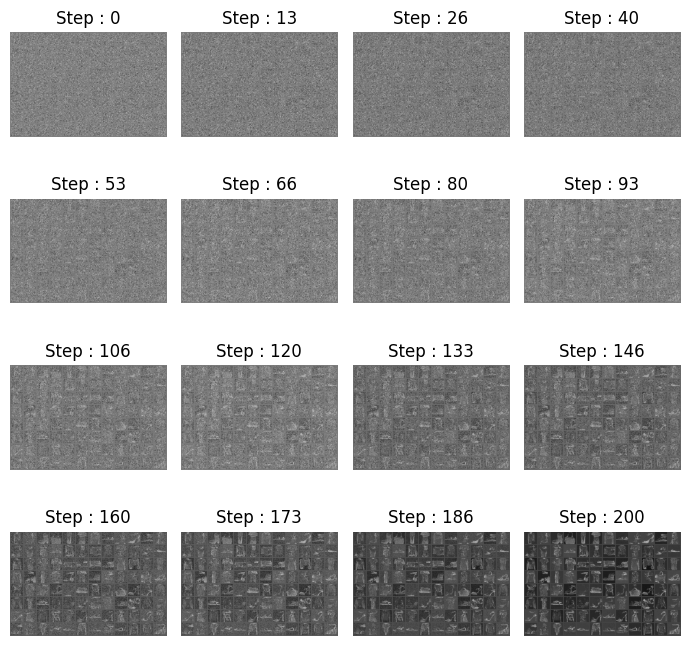

In [19]:
fig, axes = plt.subplots(4, 4, figsize=(7, 7))

for idx, x in enumerate(new_new_x_frames):
    axes[idx//4, idx%4].imshow(x, cmap="gray")
    axes[idx//4, idx%4].set_title(f"Step : {frame_idxs[idx]}")
    axes[idx//4, idx%4].axis("off")

plt.tight_layout()
plt.show()

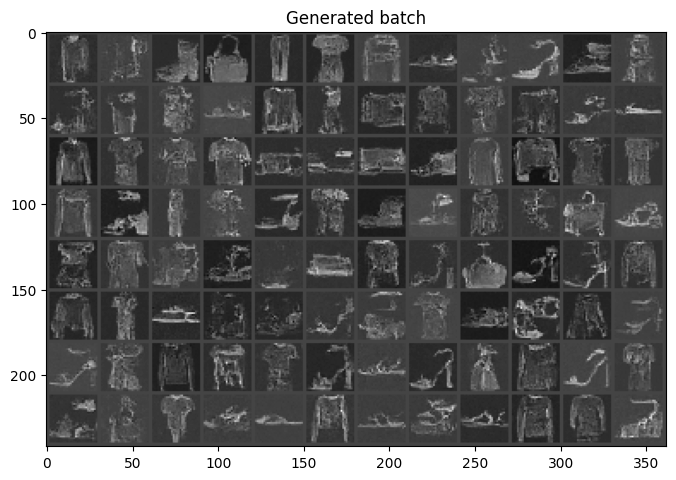

In [20]:
plt.figure(figsize=(8, 8))
plt.title("Generated batch")
plt.imshow(new_new_x_frames[-1], cmap="gray")
plt.show()